In [1]:
import os
import shutil
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from glob import glob
import cv2
from tqdm.auto import tqdm
import joblib

import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as albu
import segmentation_models_pytorch as smp


class Dataset(Dataset):
    def __init__(
            self, 
            data_dir=None,
            augmentation=None, 
            preprocessing=None,):
        self.image_paths = [p for p in glob(str(data_dir / '*.jpg'))]
        self.mask_paths = [p.split('.jpg')[0] + '.npy' for p in self.image_paths]      
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __len__(self):
        return len(self.image_paths)
        
    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = np.load(self.mask_paths[idx])
        mask = np.expand_dims(mask, axis=-1)
        
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        return image, mask


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing t      ransform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor),
    ]
    return albu.Compose(_transform)


def detect_green_color(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hsv_min = np.array([30, 64, 0])
    hsv_max = np.array([90, 255, 255])
    mask = cv2.inRange(hsv, hsv_min, hsv_max)
    masked_img = cv2.bitwise_and(img, img, mask=mask)
    return mask, masked_img

/root/.cache/pypoetry/virtualenvs/iwamasa-2022-xS3fZVNL-py3.8/lib/python3.8/site-packages/pretrainedmodels/models/dpn.py:255: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if block_type is 'proj':
/root/.cache/pypoetry/virtualenvs/iwamasa-2022-xS3fZVNL-py3.8/lib/python3.8/site-packages/pretrainedmodels/models/dpn.py:258: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif block_type is 'down':
/root/.cache/pypoetry/virtualenvs/iwamasa-2022-xS3fZVNL-py3.8/lib/python3.8/site-packages/pretrainedmodels/models/dpn.py:262: SyntaxWarning: "is" with a literal. Did you mean "=="?
  assert block_type is 'normal'


In [2]:
BASE_DIR = '../'
INFERENCE_PATH = os.path.join(BASE_DIR, 'data/processed/segment-non-treated-dataset')
IMAGE_DIR = os.path.join(BASE_DIR,  'data/interm/non-treated-dataset')

ENCODER = 'resnet18'
DECODER = 'unet'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid'
DEVICE = 'cuda'
crop_size = 512
buffer_size = 32
patch_size = crop_size - 2 * buffer_size

preprocessing_fn = smp.encoders.get_preprocessing_fn(
    ENCODER, 
    ENCODER_WEIGHTS
)
preprocessing = get_preprocessing(preprocessing_fn)
best_model = torch.load(
    os.path.join(BASE_DIR , f'models/gray_{ENCODER}_{DECODER}.pth')
)

image_paths = glob(os.path.join(IMAGE_DIR, '*'))
count = 0

for i, path in tqdm(enumerate(image_paths), total=len(image_paths)):
    file_name = path.split('/')[-1].split('.')[0]
    
    # detect grean-area
    im = cv2.imread(path)
    contours, hierarchy = cv2.findContours(
        detect_green_color(im)[0], 
        cv2.RETR_TREE, 
        cv2.CHAIN_APPROX_SIMPLE
    )
    max_contours = max(contours, key=lambda x: cv2.contourArea(x))
    mask = cv2.drawContours(
        np.zeros_like(im[:,:,0]),
        [max_contours],
        -1,
        color=255,
        thickness=-1
    )
    im = cv2.imread(path, 0)
    im = np.where(mask==255, 255-im, 255)
    
    im = np.expand_dims(im, axis=-1)
    im = np.repeat(im, 3, axis=-1)
    new_shape = [-(-im.shape[i]//patch_size)*patch_size + 2*buffer_size  for i in [0, 1]] + [3]
    reshape_im = np.ones(new_shape, dtype=np.uint8) * 255
    reshape_im[buffer_size:im.shape[0]+buffer_size, buffer_size:im.shape[1]+buffer_size, :] = im

    output_im = np.zeros((new_shape[0], new_shape[1]), dtype=np.float32)
    for h_i, h in enumerate(range(buffer_size, new_shape[0]-buffer_size, patch_size)):
        for w_i, w in enumerate(range(buffer_size, new_shape[1]-buffer_size, patch_size)):
            h -= buffer_size
            w -= buffer_size
            tmp_im = reshape_im[h:h+crop_size, w:w+crop_size, :]
            if reshape_im.mean() > 0:
                tmp_im = preprocessing(image=tmp_im)
                x_tensor = torch.from_numpy(tmp_im['image']).to(DEVICE).unsqueeze(0)
                tmp_output_im = best_model.predict(x_tensor).squeeze().cpu().numpy()
                h += buffer_size
                w += buffer_size
                output_im[h:h+patch_size, w:w+patch_size] = tmp_output_im[buffer_size:-buffer_size, buffer_size:-buffer_size]
    output_im = ((output_im)*255).astype(np.uint8)
    cv2.imwrite(os.path.join(INFERENCE_PATH, (file_name+'.png')), im)
    cv2.imwrite(os.path.join(INFERENCE_PATH, ('vein_'+file_name+'.png')), output_im)

  0%|          | 0/1 [00:00<?, ?it/s]

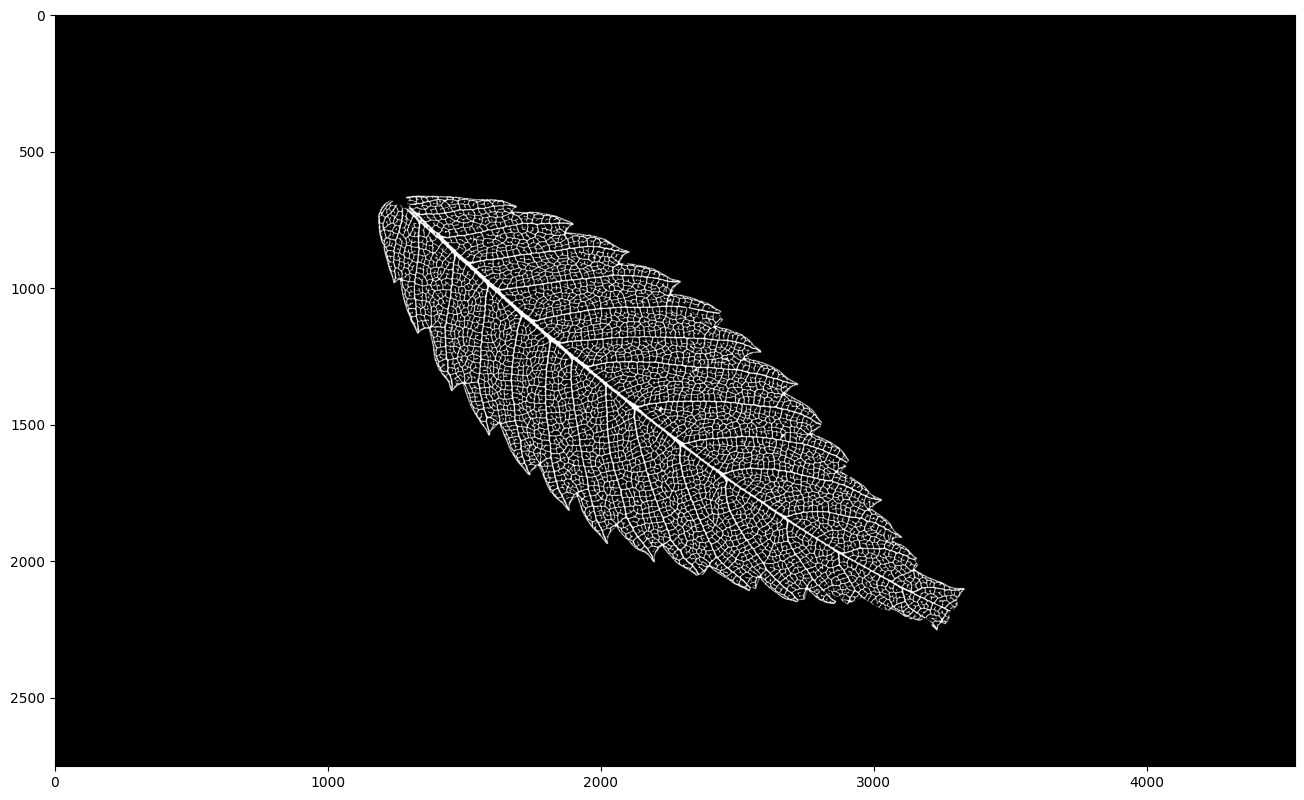

In [3]:
path = '../data/processed/segment-non-treated-dataset/vein_Zelkova_serrata_0.png'
im = cv2.imread(path, 0)

plt.figure(figsize=(16, 12))
plt.imshow(im, cmap='gray')
plt.show()